In this notebook, we train the model by excluding some classes from the training process, such as clouds or wave break.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import importlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from skimage.segmentation import mark_boundaries
import itertools
import random
import time
import pickle

C:\Users\tnguyen001\AppData\Roaming\Python\Python38\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
from coral_mapper_functions import score_map
from coral_mapper import coral_map

In [4]:
full_doc = pd.read_excel("../../../Maupiti/Data/connectivityTable.ods")

In [5]:
full_doc[:11]

,Unnamed: 0,Ocean,Reef Front,Reef Crest,Outer Reef Flat,Inner Reef,Back Reef Slope,Shallow lagoon,Lagoon,Patch Reef,Shore Reef,Land
0,Ocean,NaN,X,X,~,O,O,O,~,O,O,O
1,Reef Front,X,NaN,X,~,O,O,O,O,O,O,O
2,Reef Crest,X,X,NaN,X,~,O,O,O,O,O,O
3,Outer Reef Flat,~,~,X,NaN,X,~,O,O,O,O,O
4,Inner Reef,O,O,~,X,NaN,X,~,O,O,O,~
5,Back Reef Slope,O,O,O,~,X,NaN,O,~,O,O,~
6,Shallow lagoon,O,O,O,O,~,O,NaN,X,X,X,~
7,Lagoon,~,O,O,O,O,~,X,NaN,X,X,~
8,Patch Reef,O,O,O,O,O,O,X,X,NaN,X,~
9,Shore Reef,O,O,O,O,O,O,X,X,X,NaN,X


In [6]:
connectivity = full_doc[:11].replace('O',1).replace('X',0).replace('~',2)

In [7]:
connectivity

,Unnamed: 0,Ocean,Reef Front,Reef Crest,Outer Reef Flat,Inner Reef,Back Reef Slope,Shallow lagoon,Lagoon,Patch Reef,Shore Reef,Land
0,Ocean,NaN,0.0,0.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0
1,Reef Front,0.0,NaN,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,Reef Crest,0.0,0.0,NaN,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0
3,Outer Reef Flat,2.0,2.0,0.0,NaN,0.0,2.0,1.0,1.0,1.0,1.0,1.0
4,Inner Reef,1.0,1.0,2.0,0.0,NaN,0.0,2.0,1.0,1.0,1.0,2.0
5,Back Reef Slope,1.0,1.0,1.0,2.0,0.0,NaN,1.0,2.0,1.0,1.0,2.0
6,Shallow lagoon,1.0,1.0,1.0,1.0,2.0,1.0,NaN,0.0,0.0,0.0,2.0
7,Lagoon,2.0,1.0,1.0,1.0,1.0,2.0,0.0,NaN,0.0,0.0,2.0
8,Patch Reef,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,NaN,0.0,2.0
9,Shore Reef,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,NaN,0.0


In [8]:
connectivity.set_index('Unnamed: 0', inplace=True)

In [9]:
classes_type = ['Back Reef Slope', 'Inner Reef', 'Lagoon', 'Land', 'Ocean',
                'Outer Reef Flat ', 'Patch Reef', 'Reef Crest', 'Reef Front', 'Shallow lagoon', 'Shore Reef ']

In [10]:
mapping = {name: i for i, name in zip(np.arange(1,12), classes_type)}
mapping

{'Back Reef Slope': 1,
 'Inner Reef': 2,
 'Lagoon': 3,
 'Land': 4,
 'Ocean': 5,
 'Outer Reef Flat ': 6,
 'Patch Reef': 7,
 'Reef Crest': 8,
 'Reef Front': 9,
 'Shallow lagoon': 10,
 'Shore Reef ': 11}

In [11]:
connectivity = connectivity.rename(columns=mapping)
connectivity = connectivity.rename(index=mapping)
connectivity

,5,9,8,6,2,1,10,3,7,11,4
Unnamed: 0,,,,,,,,,,,
5,NaN,0.0,0.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0
9,0.0,NaN,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
8,0.0,0.0,NaN,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0
6,2.0,2.0,0.0,NaN,0.0,2.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,2.0,0.0,NaN,0.0,2.0,1.0,1.0,1.0,2.0
1,1.0,1.0,1.0,2.0,0.0,NaN,1.0,2.0,1.0,1.0,2.0
10,1.0,1.0,1.0,1.0,2.0,1.0,NaN,0.0,0.0,0.0,2.0
3,2.0,1.0,1.0,1.0,1.0,2.0,0.0,NaN,0.0,0.0,2.0
7,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,NaN,0.0,2.0


# Loading the maps

In [12]:
img_rugo_zones = np.load('../v2/data/pleiades_map_types_10m.npy')
img_rugo_subtypes = np.load('../v2/data/pleiades_map_subtypes_10m.npy')
pleiades_img = np.load('../v2/data/pleiades_ortho_10m.npy')

In [13]:
img_blue = (pleiades_img[1]-np.mean(pleiades_img[1]))/np.std(pleiades_img[1])
img_green = (pleiades_img[2]-np.mean(pleiades_img[2]))/np.std(pleiades_img[2])
img_red = (pleiades_img[3]-np.mean(pleiades_img[3]))/np.std(pleiades_img[3])
img_nir = (pleiades_img[0]-np.mean(pleiades_img[0]))/np.std(pleiades_img[0])

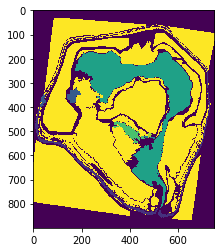

In [14]:
plt.imshow(img_rugo_subtypes, interpolation='None')
plt.show()

In [ ]:
# breaking is 1, cloud is 2

In [29]:
img_rugo_2 = np.copy(img_rugo_zones)
img_rugo_2[img_rugo_subtypes == 1] = 0
img_rugo_2[img_rugo_subtypes == 2] = 0

In [31]:
map_test = coral_map([img_blue,img_green,img_red,img_nir], map_img=img_rugo_2, size_img=5)

In [39]:
classified_pixels = np.where(img_rugo_2>0)

In [40]:
random.seed(0)
size_subset = len(classified_pixels[0][:len(classified_pixels[0])//2])
index_combination = list(np.array(classified_pixels).T)
random_train_test = random.sample(index_combination,size_subset)
training_set_indexes_pb = random_train_test[:size_subset//5]
testing_set_indexes_pb = random_train_test[size_subset//5:]

In [41]:
print(size_subset)

214270


In [42]:
%%time
map_test.train_pixelbased_rf(training_set_indexes_pb, testing_set_indexes_pb, undersampling=0)

C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:96: UserWarning: The training set does not contain all the classes. Errors may occur.
  warnings.warn("The training set does not contain all the classes. Errors may occur.")


Creating the labels for each superpixel...
Creating the features for each superpixel...
Training the Random Forest classifier...
Validation accuracy: 0.9773591730060205
Wall time: 2min 4s


In [43]:
%%time
map_test.predict_map_pixelbased_rf()

Wall time: 12.2 s


In [45]:
predicted_map_pixelbased_rf_classes = np.argmax(map_test.predicted_map_pb_rf,axis=2)+1
score_map(img_rugo_2,predicted_map_pixelbased_rf_classes,[0,4,5], map_test.segments, training_set_indexes_pb, [], size_superpixel=5)

0.8543046357615894

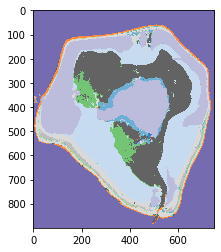

In [46]:
plt.imshow(predicted_map_pixelbased_rf_classes, interpolation='None', cmap='tab20c_r')
plt.show()

In [22]:
np.save('data/prediction_pb_10m.npy', predicted_map_pixelbased_rf_classes)

In [47]:
from skimage.segmentation import felzenszwalb

In [48]:
img_rgb_without_pb = np.dstack([img_blue,img_green,img_red])
img_rgb_with_pb = np.dstack([img_blue, img_green, img_red, predicted_map_pixelbased_rf_classes])

In [49]:
img_rgb_with_pb = np.copy(img_rgb_without_pb)
for i in np.unique(predicted_map_pixelbased_rf_classes):
    temp_array_class = np.zeros(np.shape(predicted_map_pixelbased_rf_classes))
    temp_array_class[predicted_map_pixelbased_rf_classes==i] = 1
    img_rgb_with_pb = np.dstack([img_rgb_with_pb, temp_array_class])

In [50]:
segments = felzenszwalb(img_rgb_with_pb, scale=1.5, sigma=1., min_size=50)

<ipython-input-50-06dae735733f>:1: RuntimeWarning: Got image with third dimension of 15. This image will be interpreted as a multichannel 2d image, which may not be intended.
  segments = felzenszwalb(img_rgb_with_pb, scale=1.5, sigma=1., min_size=50)


In [51]:
map_test.segments = segments

In [52]:
map_test.smooth_pb_rf()

In [53]:
map_test.smoothed_map_pb_rf = map_test.smoothed_map_pb_rf+1

In [54]:
smooth_map = np.copy(map_test.smoothed_map_pb_rf)

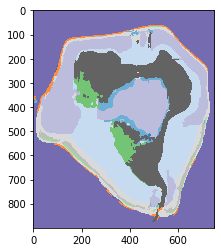

In [55]:
plt.imshow(smooth_map, interpolation='None', cmap='tab20c_r')
plt.show()

In [56]:
score_map_smooth = score_map(img_rugo_2, smooth_map,[0,4,5], map_test.segments, training_set_indexes_pb, [], size_superpixel=5)
print(score_map_smooth)

0.6821192052980133


In [33]:
np.save('data/smooth_map_10m.npy',smooth_map)

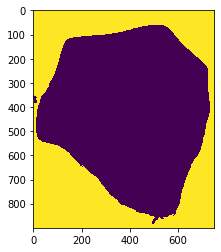

In [34]:
mask = np.zeros(np.shape(smooth_map))
mask[smooth_map == 5] = 1
plt.imshow(mask, interpolation='None')
plt.show()

# Post processing

In [34]:
list_scores_post_processing = []
list_thresholds_post_processing = []

In [17]:
predicted_map_pixelbased_rf_classes = np.load('data/prediction_pb_10m.npy')
smooth_map = np.load('data/smooth_map_10m.npy')

In [57]:
import segments_regressor
from skimage.segmentation import find_boundaries

In [58]:
segments_classes = np.copy(map_test.y_segments_pb_rf_classes)
segments_classes

array([4, 4, 4, ..., 4, 4, 4], dtype=int64)

In [59]:
boundaries = find_boundaries(map_test.segments)
adjacent_segments,_ = segments_regressor.find_adjacent_segments(map_test.segments, boundaries)

In [60]:
%%time
list_wrong_neighbours = []
for i in range(len(adjacent_segments)):
    wrong_neighbours = 0
    s = adjacent_segments[i]
    s_class = segments_classes[i]
    if s_class > 0:
        s_connectivity = connectivity[s_class]
        for j in s:
            if segments_classes[j]>0:
                if s_connectivity[segments_classes[j]] == 0 :
                    wrong_neighbours += 1
    list_wrong_neighbours.append(wrong_neighbours/len(s))

Wall time: 56 ms


In [61]:
threshold = 0.8
nb_wrong_segments=0
for i, value in enumerate(list_wrong_neighbours):
    if value>0:
        #assign the majority of neighbours to this segment
        nb_wrong_segments+=1
        lst_temp = [segments_classes[j] for j in adjacent_segments[i]]
        majority_neighbours = max(set(lst_temp), key=lst_temp.count)
        if majority_neighbours/len(lst_temp) > threshold:
            segments_classes[i] = majority_neighbours
print(nb_wrong_segments)

157


In [247]:
# applying the above and recomputing list_wrong_neighbours gives the following nb of wrong segments:
nb_wrong_segments=0
for i, value in enumerate(list_wrong_neighbours):
    if value>0:
        nb_wrong_segments+=1
print(nb_wrong_segments)

314


In [62]:
new_map = np.copy(segments)
for i in range(np.max(segments)+1):
    new_map[segments==i] = segments_classes[i]+1

In [63]:
score_pp = score_map(img_rugo_2,new_map,[0,4,5], map_test.segments, training_set_indexes_pb, [], size_superpixel=5)
score_pp

0.6903973509933775

In [42]:
np.unique(new_map)

array([ 1,  2,  3,  4,  5,  6,  7,  9, 10, 11, 12], dtype=int64)

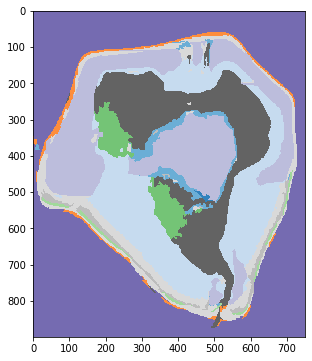

In [64]:
plt.figure(figsize=(6,6))
plt.imshow(new_map, interpolation='None', cmap='tab20c_r')
plt.show()